In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
pd.options.display.max_columns = None
from keras.models import Sequential
from keras.layers import Dense, LSTM
import sklearn.metrics as m
from matplotlib import pyplot
from keras import backend as K

Using TensorFlow backend.


In [63]:
data_path = 'data/flat_data.npy'
names_path = 'data/flat_names.npy'
data_path = 'data/flat_data_extra.npy'
names_path = 'data/flat_names_extra.npy'

# load data from .npy files into numpy arrays
data = np.load(data_path)
names = np.load(names_path)
samples = len(data)
time_steps = 20
features = 107


X = data[:,2:].reshape((samples, time_steps, features))
Y = data[:, 1:2].reshape((samples))

epochs = 40
batch_size = 10


In [64]:
train_X, test_X, train_Y, test_Y, train_names, test_names = train_test_split(X, Y, names, test_size=0.30, random_state=42)

In [65]:
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

unique, counts = np.unique(Y, return_counts=True)
class_weight={
    1: counts[0] / counts[1] * 1
}
class_weight

{1: 2.2337662337662336}

In [66]:
# build LSTM layers
model = Sequential()
model.add(LSTM(100, dropout=0.2, input_shape=(time_steps, features)))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', specificity, sensitivity])
print(model.summary())
model.fit(train_X, train_Y, validation_data=(test_X, test_Y), epochs=epochs, batch_size=batch_size, verbose=0)

print('done')


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 100)               83200     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 101       
Total params: 83,301
Trainable params: 83,301
Non-trainable params: 0
_________________________________________________________________
None
done


In [67]:
yhat = model.predict_classes(test_X)[:, 0]
# score model and log accuracy and parameters
scores = model.evaluate(test_X, test_Y, verbose=0)
probs = model.predict(test_X)
precision, recall, thresholds = m.precision_recall_curve(test_Y, probs)

print("Accuracy: %.2f%%" % (scores[1]*100))
print("Specificity: %.2f%%" % (scores[2]*100))
print("Sensitivity: %.2f%%" % (scores[3]*100))
print("Precision: %.2f%%" % (precision[0]*100))
print("Recall: %.2f%%" % (recall[0]*100))
print("Threshold: %.9f" % thresholds[0])
print('Confusion Matrix\n', m.confusion_matrix(test_Y, yhat))

f = np.where(probs > thresholds[0])
false_positives = np.logical_and(test_Y != yhat, yhat == 1)
false_negatives = np.logical_and(test_Y != yhat, yhat == 0)

print('False Positives\n', test_names[false_positives])
print('False Negatives\n', test_names[false_negatives])

Accuracy: 90.91%
Specificity: 94.13%
Sensitivity: 83.71%
precision: 74.38%
recall: 100.00%
thresholds: 0.120316982
Confusion Matrix
 [[240  15]
 [ 19 100]]
False Positives
 ['Clifford Robinson' 'Joe Johnson' 'Sam Cassell' 'LeBron James'
 'Byron Scott' 'Latrell Sprewell' 'Zach Randolph' 'Dell Curry' 'Ray Allen'
 'Charles Oakley' 'Grant Hill' 'Steve Smith' 'Richard Hamilton'
 'DeMarcus Cousins' 'Wayman Tisdale']
False Negatives
 ['Yao Ming' 'Arvydas Sabonis' 'Dennis Johnson' 'Julius Erving'
 'Arvydas Sabonis' 'Dennis Johnson' 'Arvydas Sabonis' 'Yao Ming'
 'Julius Erving' 'Dennis Johnson' 'Arvydas Sabonis' 'Dennis Johnson'
 'Yao Ming' 'Julius Erving' 'Arvydas Sabonis' 'Julius Erving'
 'Dennis Johnson' 'Yao Ming' 'Julius Erving']


ROC_AUC: 0.966


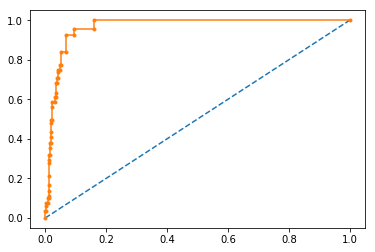

f1=0.855 auc=0.884 ap=0.890


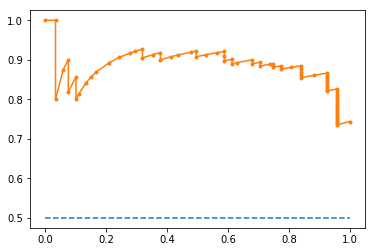

In [68]:




# calculate AUC
roc = m.roc_auc_score(test_Y, probs)
print('ROC_AUC: %.3f' % roc)
# calculate roc curve
fpr, tpr, thresholds = m.roc_curve(test_Y, probs)
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.')
# show the plot
pyplot.show()



# calculate F1 score
f1 = m.f1_score(test_Y, yhat)
# calculate precision-recall AUC
auc = m.auc(recall, precision)
# calculate average precision score
ap = m.average_precision_score(test_Y, probs)
print('f1=%.3f auc=%.3f ap=%.3f' % (f1, auc, ap))
# plot no skill
pyplot.plot([0, 1], [0.5, 0.5], linestyle='--')
# plot the roc curve for the model
pyplot.plot(recall, precision, marker='.')
# show the plot
pyplot.show()